<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/template%20Series%20temporales/ARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo autorregresivo con heterocedasticidad condicional

$$ \sigma_{t}^{2} = \alpha_{0}+\alpha_{1}\epsilon_{t-1}^{2} $$

Permite predecir la varianza del modelo

## Importación de datos

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")
sns.set()

#Prueba Logverosimilitud
# requiere que los modelos esten anidados
# p1 + q1 > p2 +q2
# p1 >= p2
# q1 >= q2
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

# carga de archivo
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/cccg8105/curso-series-temporales/master/7.%20ARMA%20autorregresivos%20de%20medias%20moviles/Python/Index2018.csv")
raw_csv_data.head(5)

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


### Formateo de datos

In [2]:
dateColumnName = "date"
analizedValue = "ftse"
unused_columns = ['spx','dax','ftse','nikkei']

df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

# Formateo de dataset
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp[dateColumnName], dayfirst = True)
df_comp.set_index(dateColumnName, inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

df_comp['analizedValue']=df_comp[analizedValue]

df_comp = df_comp.drop(unused_columns, axis=1)
# data frame para analizar
df_comp.head(5)

,analizedValue
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


### Separación en entrenamiento y prueba

In [3]:
porcentajeEntrenamiento = 0.8
size = int(len(df_comp)*porcentajeEntrenamiento)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Serie temporal

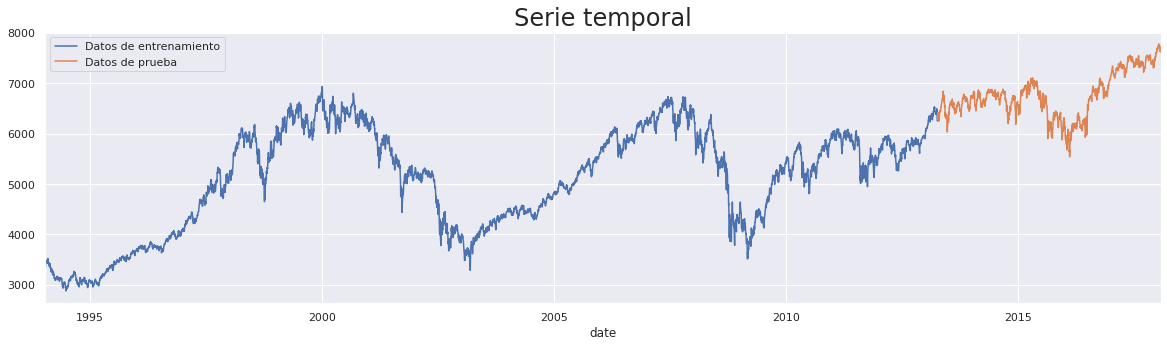

In [4]:
df.analizedValue.plot(figsize = (20,5), label = 'Datos de entrenamiento')
df_test.analizedValue.plot(figsize = (20,5), label = 'Datos de prueba')
plt.title("Serie temporal", size= 24)
plt.legend(loc='upper left')
plt.show()

## Retornos

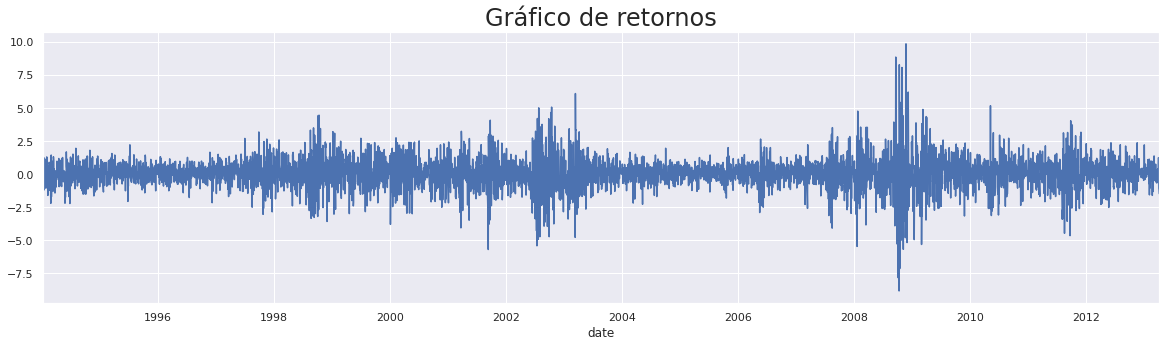

In [6]:
df['returns'] = df.analizedValue.pct_change(1)*100
df.returns.plot(figsize = (20,5), label = 'Retornos')
plt.title("Gráfico de retornos", size= 24)
plt.show()

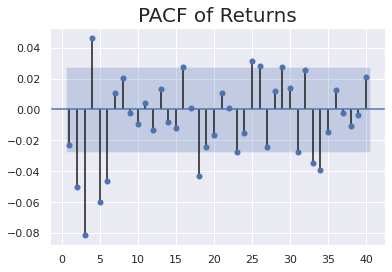

In [8]:
sgt.plot_pacf(df.returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.show()

## Volatilidad

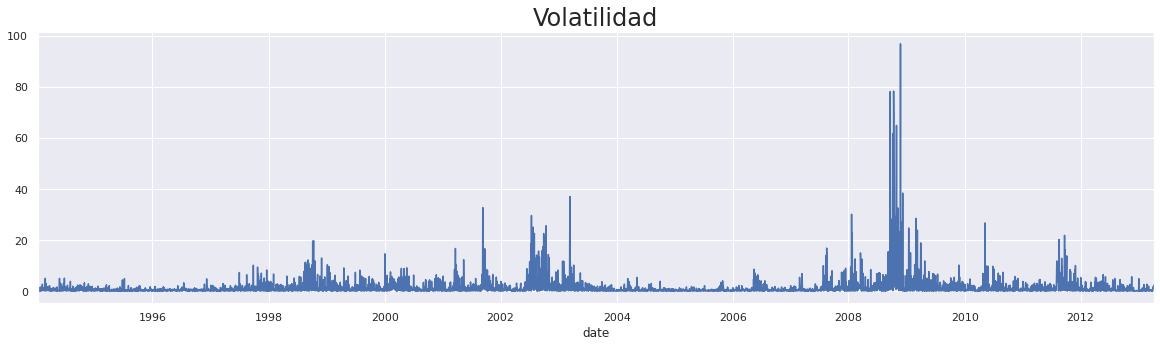

In [7]:
df['sq_returns'] = df.returns.mul(df.returns)
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatilidad", size = 24)
plt.show()

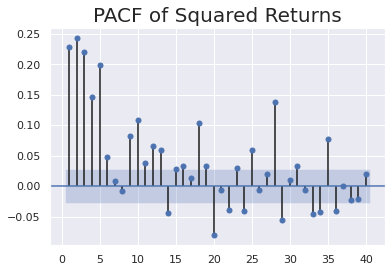

In [9]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.show()

## Modelo Arch

In [10]:
!pip install arch

     |████████████████████████████████| 798kB 5.5MB/s 


In [14]:
from arch import arch_model

model_arch_1 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 7660.088789377838
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Mon, Nov 23 2020   Df Residuals:                     5017
Time:                        23:06:46   Df Model:                            3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

## ARCH N

In [15]:
model_arch_2 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7449.870533644225
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7449.545164098316
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Mon, Nov 23 2020   Df Residuals:                     5016
Time:                        23:14:58   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [16]:
model_arch_13 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 13)
results_arch_13 = model_arch_13.fit(update_freq = 5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     93,   Neg. LLF: 6996.500043707073
Iteration:     10,   Func. Count:    188,   Neg. LLF: 6985.661375673177
Iteration:     15,   Func. Count:    283,   Neg. LLF: 6984.395178347233
Iteration:     20,   Func. Count:    378,   Neg. LLF: 6984.218261212904
Iteration:     25,   Func. Count:    468,   Neg. LLF: 6984.175140343418
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6984.175062618146
            Iterations: 27
            Function evaluations: 502
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -6984.18
Distribution:                  Normal   AIC:                           13998.4
Method:            Maximum Likelihood   BIC:                           14096.2
                                        No. Observations:                 5020
Date:                Mon, Nov 23 2020   Df Residuals:                     5005
Time:                        23:17:10   Df Model:                           15
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0492  1.206e-02      4.077  4.566e-05 [2.553e-02,7.281e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1871  2.210e-02      8.466  2.538e-17      [  0.144,  0.230]
alpha[1]       0.0568  1.729e-02      3.282  1.029e-03  [2.287e-02,9.065e-02]
alpha[2]       0.1156  2.017e-02      5.733  9.840e-09    [7.610e-02,  0.155]
alpha[3]       0.1265  2.625e-02      4.820  1.433e-06    [7.509e-02,  0.178]
alpha[4]       0.0884  2.159e-02      4.093  4.265e-05    [4.605e-02,  0.131]
alpha[5]       0.0695  1.750e-02      3.970  7.189e-05    [3.518e-02,  0.104]
alpha[6]       0.0865  1.926e-02      4.491  7.092e-06    [4.874e-02,  0.124]
alpha[7]       0.0404  1.846e-02      2.188  2.870e-02  [4.203e-03,7.658e-02]
alpha[8]       0.0654  1.833e-02      3.565  3.633e-04    [2.943e-02,  0.101]
alpha[9]       0.0292  1.603e-02      1.820  6.877e-02 [-2.245e-03,6.058e-02]
alpha[10]      0.0335  1.605e-02      2.089  3.670e-02  [2.072e-03,6.498e-02]
alpha[11]      0.0775  1.760e-02      4.403  1.067e-05    [4.300e-02,  0.112]
alpha[12]      0.0473  1.873e-02      2.526  1.153e-02  [1.060e-02,8.402e-02]
alpha[13]      0.0372  1.431e-02      2.600  9.317e-03  [9.162e-03,6.526e-02]
=============================================================================

Covariance estimator: robust
"""